### 预训练模型加载
已经实现的简化CNN能够跑到50%+的正确率，并不够理想。vgg-16可能是调参的问题，正确率也上不到50%（小类正确率）。期望能够基于预训练的vgg-19进行迁移学习。

基于预训练模型，已经实现了输入图片的缩放（因此不限制输入图片尺寸，图片size<256\*256亦可）和分类。已经搭建好迁移学习的框架，见另一个文件。

模型效果：vgg-16 < resnet101 < vgg-19

为了实现更好的效果，期望完成基于目标检测和图像分割的多分类（现有的YOLO4等分类结果有限，如果能识别目标并切割图片，再输入现有分类器，效果应该不错，不过只是个设想。）

In [1]:
from torchvision import models

ModuleNotFoundError: No module named 'torchvision'

In [2]:
#res101 = models.resnet101(pretrained=True)
vgg19 = models.vgg19_bn(pretrained=True)

NameError: name 'models' is not defined

In [3]:
net = vgg19

NameError: name 'vgg19' is not defined

In [4]:
from torchvision import models
import torch

In [5]:
from torchvision import transforms 
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

https://blog.csdn.net/heiheiya/article/details/103031300

### 迁移学习

有待实现。

In [11]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
 
import numpy as np
import matplotlib.pyplot as plt
import os
 
apply_transform = { #数据增强
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

NameError: name 'transforms' is not defined

In [7]:
#加载数据集

train_dataset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True, download=True,transform=apply_transform['train'])
test_dataset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False, download=False,transform=apply_transform['test'])
 

Files already downloaded and verified


In [8]:
#修改预训练模型参数，进行迁移学习
vgg19 = models.vgg19_bn(pretrained=True)
#vgg19.classifier._modules['6'] = nn.Sequential(nn.Linear(4096, 100), nn.Softmax(dim=1)) #可以softmax，也可以不用

In [ ]:
for param in vgg19.parameters():
    param.requires_grad = False

In [ ]:
vgg19.classifier._modules['6'] = nn.Linear(4096, 100)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)#定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1,weight_decay=8e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=5e-4)

In [ ]:
#如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
net = net.to(device)

#训练模型
print('training on: ',device)
def test(): 
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    with torch.no_grad(): #预测时不需要构建计算图，使用with torch.no_grad() 加快运行速度
        for batch, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            acc+=torch.sum(torch.argmax(output,dim=1)==target).item()
            sum+=len(target)
            loss_sum+=loss.item()
    print('test  acc: %.2f%%, loss: %.4f'%(100*acc/sum, loss_sum/(batch+1)))

def train(): 
        net.train()
        acc = 0.0
        sum = 0.0
        loss_sum = 0
        for batch, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            acc +=torch.sum(torch.argmax(output,dim=1)==target).item()
            #print(f'output={torch.argmax(output,dim=1)},target={target}')
            sum+=len(target)
            loss_sum+=loss.item()
            
            if batch%200==0:
                print('\tbatch: %d, loss: %.4f'%(batch, loss.item()))
            
            # 清除循环变量，避免出现显存爆炸
            del data, target, output
            torch.cuda.empty_cache()
        print('train acc: %.2f%%, loss: %.4f'%(100*acc/sum, loss_sum/(batch+1)))

for epoch in range(20):
    print('epoch: %d'%epoch)
    train()
    test()
    PATH = './Poems/vgg_19_model_dict.pth'
    #保存
    torch.save(net.state_dict(), PATH)

In [ ]:
torch.cuda.empty_cache()

### 数据标注
下一步需要建立标签到传统古诗用语上的映射。尚未完成，只给出示例。可以手工标注。最终模型效果很大程度上取决于数据标注质量。（也是超越之前小组的地方）。

In [6]:
import json

In [7]:
# 将类文件对象中的JSON字符串直接转换成 Python 字典
def readdict():
    global ret_dic
    with open('./data/tags.json', 'r', encoding='utf-8') as f:
        ret_dic = json.load(f)
    return
        
# 效果测试
readdict()
print(type(ret_dic)) # 结果 <class 'dict'>
print(ret_dic['7']) 
print(ret_dic['1'])

<class 'dict'>
['cock', '雄鸡']
['goldfish', 'Carassius auratus', '金鱼', '鲤']


### 图片接口定义

In [14]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

In [15]:
def readimg( PATH, net=net,tag_num=1,info=False):

    img = cv.imread(PATH)
    # 显示原图
    #cv.imshow('OriginalPicture', img)
    # ，输出尺寸格式为（宽，高）
    img_test1 = cv.resize(img, (512, 512))
    #img_test1 = cv.resize(img, (224, 224),interpolation=cv.INTER_NEAREST)
    #cv.imshow('resize0', img_test1)
    #cv.waitKey()

    # 最近邻插值法缩放
    img_test2 = cv.resize(img, (512, 512),interpolation=cv.INTER_NEAREST)
    #cv.imshow('resize1', img_test2)
    #cv.waitKey()
    #cv.destroyAllWindows()
    
    img = Image.fromarray(img_test1, mode='RGB')
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    
    net = vgg19
    # Second, put the network in eval mode
    net.eval()

    # Third, carry out model inference
    out = net(batch_t)

    # Forth, print the top tag_num classes predicted by the model
    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

    tags=indices[0][:tag_num].numpy()
    accuracy=[(percentage[idx].item()) for idx in indices[0][:tag_num]]
    
    if info==True:
        img=Image.open(PATH)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        #展示效果readimg
        for i in range(tag_num):
            print(f'Top {i+1} ：tag编号：{tags[i]}，预测类别：{ret_dic[str(tags[i])]}，预测概率：{accuracy[i]}')
        return ret_dic[str(tags[0])]

    else:
        #与下一阶段接口readimg
        return ret_dic[str(tags[0])]


### 图片接口效果展示

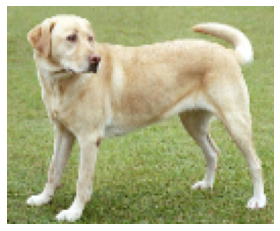

Top 1 ：tag编号：208，预测类别：['Labrador retriever', '狗', '犬', '吠']，预测概率：53.43106460571289
Top 2 ：tag编号：246，预测类别：['Great Dane']，预测概率：12.438713073730469
Top 3 ：tag编号：178，预测类别：['Weimaraner']，预测概率：4.1017231941223145
Top 4 ：tag编号：167，预测类别：['English foxhound']，预测概率：3.006983995437622
Top 5 ：tag编号：176，预测类别：['Saluki', 'gazelle hound']，预测概率：2.8754475116729736


['Labrador retriever', '狗', '犬', '吠']

In [16]:
# 效果比较好的
readdict()
readimg("dog.jpg",tag_num=5,info=True)

In [17]:
readdict() #每次更新关键词后，在这里更新

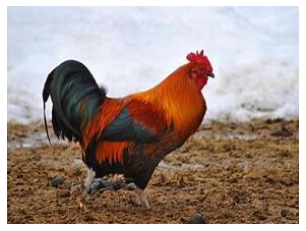

Top 1 ：tag编号：7，预测类别：['cock', '雄鸡']，预测概率：66.78863525390625
Top 2 ：tag编号：80，预测类别：['black grouse']，预测概率：21.538476943969727


['cock', '雄鸡']

In [18]:
# 比较好的
readdict()
readimg("cock.jpg",tag_num=2,info=True)

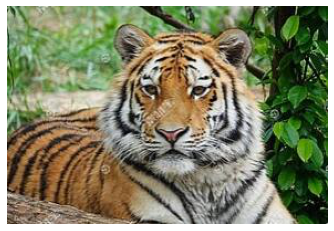

Top 1 ：tag编号：292，预测类别：['tiger', 'Panthera tigris', '虎', '霸']，预测概率：94.18677520751953
Top 2 ：tag编号：282，预测类别：['tiger cat']，预测概率：5.2397565841674805


['tiger', 'Panthera tigris', '虎', '霸']

In [19]:
# 比较好的
readdict()
readimg("tiger.jpg",tag_num=2,info=True)

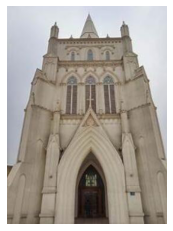

Top 1 ：tag编号：663，预测类别：['monastery', '修道院', '庙宇', '亭']，预测概率：32.90587615966797
Top 2 ：tag编号：497，预测类别：['church', 'church building']，预测概率：24.103239059448242
Top 3 ：tag编号：442，预测类别：['bell cote', 'bell cot']，预测概率：22.781997680664062
Top 4 ：tag编号：884，预测类别：['vault']，预测概率：5.418723106384277
Top 5 ：tag编号：698，预测类别：['palace']，预测概率：5.36402702331543


['monastery', '修道院', '庙宇', '亭']

In [20]:
#可以牵强解释的
readdict()
readimg("church.jpg",net=net,tag_num=5,info=True)

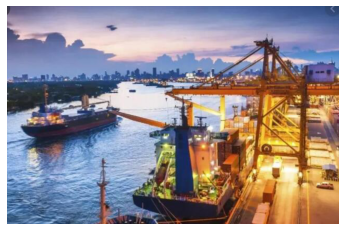

Top 1 ：tag编号：536，预测类别：['dock', 'dockage', 'docking facility', '津', '渡', '船', '帆']，预测概率：40.768150329589844
Top 2 ：tag编号：510，预测类别：['container ship', 'containership', 'container vessel']，预测概率：33.012001037597656
Top 3 ：tag编号：540，预测类别：['drilling platform', 'offshore rig']，预测概率：11.18598461151123


['dock', 'dockage', 'docking facility', '津', '渡', '船', '帆']

In [21]:
# 有发挥空间的
readdict()
readimg("dock.jpg",net=net,tag_num=3,info=True)

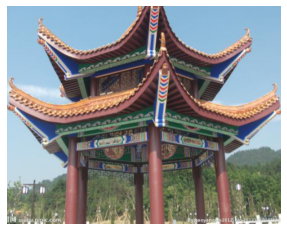

Top 1 ：tag编号：594，预测类别：['harp', '竖琴']，预测概率：54.60313034057617
Top 2 ：tag编号：839，预测类别：['suspension bridge', '吊桥']，预测概率：19.085874557495117
Top 3 ：tag编号：442，预测类别：['bell cote', 'bell cot']，预测概率：17.971805572509766
Top 4 ：tag编号：718，预测类别：['pier']，预测概率：1.3007053136825562
Top 5 ：tag编号：698，预测类别：['palace']，预测概率：0.7496532797813416


['harp', '竖琴']

In [22]:
# 比较离谱的
#ImageNet没有亭子，就离谱
readdict()
readimg("tingzi.jpg",net=net,tag_num=5,info=True)

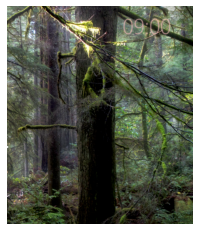

Top 1 ：tag编号：839，预测类别：['suspension bridge', '吊桥']，预测概率：64.7130126953125
Top 2 ：tag编号：888，预测类别：['viaduct']，预测概率：4.677390098571777
Top 3 ：tag编号：979，预测类别：['valley', 'vale']，预测概率：3.570732593536377
Top 4 ：tag编号：84，预测类别：['peacock']，预测概率：1.8945399522781372
Top 5 ：tag编号：286，预测类别：['cougar', 'puma', 'catamount', 'mountain lion', 'painter', 'panther', 'Felis concolor']，预测概率：1.6747031211853027


['suspension bridge', '吊桥']

In [24]:
# 超级离谱的
readimg("test.jpg",net=net,tag_num=5,info=True)

### 数据预处理
有待完成，这里只是基于一张已有图片做了示例。
这一步很关键！后续模型效果很大程度上取决于这一步~

### 基于LSTM作诗过程
抄的，不过自己已经跑过1000+epoch，勉强可以看，也许还有提升空间。基本架构可以参考，最好能改写为pytorch版本。

这一部分最关键，需要花功夫实现。

In [25]:
import random
import os

import keras
import numpy as np
from keras.callbacks import LambdaCallback
from keras.models import Input, Model, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

from poem_data_utils import *


In [26]:
class PoetryModel(object):
    def __init__(self, config):
        self.model = None
        self.do_train = True
        self.loaded_model = True
        self.config = config

        # 文件预处理
        self.word2numF, self.num2word, self.words, self.files_content = preprocess_file(self.config)
        
        # 诗的list
        self.poems = self.files_content.split(']')
        # 诗的总数量
        self.poems_num = len(self.poems)
        
        # 如果模型文件存在则直接加载模型，否则开始训练
        if os.path.exists(self.config.weight_file) and self.loaded_model:
            self.model = load_model(self.config.weight_file)
        else:
            self.train()

    def build_model(self):
        '''建立模型'''
        print('building model')

        # 输入的dimension
        input_tensor = Input(shape=(self.config.max_len, len(self.words)))
        lstm = LSTM(512, return_sequences=True)(input_tensor)
        dropout = Dropout(0.6)(lstm)
        lstm = LSTM(256)(dropout)
        dropout = Dropout(0.6)(lstm)
        dense = Dense(len(self.words), activation='softmax')(dropout)
        self.model = Model(inputs=input_tensor, outputs=dense)
        optimizer = Adam(lr=self.config.learning_rate)
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def sample(self, preds, temperature=1.0):
        '''
        当temperature=1.0时，模型输出正常
        当temperature=0.5时，模型输出比较open
        当temperature=1.5时，模型输出比较保守
        在训练的过程中可以看到temperature不同，结果也不同
        就是一个概率分布变换的问题，保守的时候概率大的值变得更大，选择的可能性也更大
        '''
        preds = np.asarray(preds).astype('float64')
        exp_preds = np.power(preds,1./temperature)
        preds = exp_preds / np.sum(exp_preds)
        pro = np.random.choice(range(len(preds)),1,p=preds)
        return int(pro.squeeze())
    
    def generate_sample_result(self, epoch, logs):
        '''训练过程中，每4个epoch打印出当前的学习情况'''
        if epoch % 4 != 0:
            return
        
        with open('out/out.txt', 'a',encoding='utf-8') as f:
            f.write('==================Epoch {}=====================\n'.format(epoch))
                
        print("\n==================Epoch {}=====================".format(epoch))
        for diversity in [0.7, 1.0, 1.3]:
            print("------------Diversity {}--------------".format(diversity))
            generate = self.predict_random(temperature=diversity)
            print(generate)
            
            # 训练时的预测结果写入txt
            #可以改为json格式
            with open('out/out.txt', 'a',encoding='utf-8') as f:
                f.write(generate+'\n')
    
    def predict_random(self,temperature = 1):
        '''随机从库中选取一句开头的诗句，生成五言绝句'''
        if not self.model:
            print('model not loaded')
            return
        
        index = random.randint(0, self.poems_num)
        sentence = self.poems[index][: self.config.max_len]
        generate = self.predict_sen(sentence,temperature=temperature)
        return generate
    
    def predict_first(self, char,temperature =1):
        '''根据给出的首个文字，生成五言绝句'''
        if not self.model:
            print('model not loaded')
            return
        
        index = random.randint(0, self.poems_num)
        #选取随机一首诗的最后max_len字符+给出的首个文字作为初始输入
        sentence = self.poems[index][1-self.config.max_len:] + char
        generate = str(char)
#         print('first line = ',sentence)
        # 直接预测后面23个字符
        generate += self._preds(sentence,length=23,temperature=temperature)
        return generate
    
    def predict_sen(self, text,temperature =1):
        '''根据给出的前max_len个字，生成诗句'''
        '''此例中，即根据给出的第一句诗句（含逗号），来生成古诗'''
        if not self.model:
            return
        max_len = self.config.max_len
        if len(text)<max_len:
            print('length should not be less than ',max_len)
            return

        sentence = text[-max_len:]
        print('the first line:',sentence)
        generate = str(sentence)
        generate += self._preds(sentence,length = 24-max_len,temperature=temperature)
        return generate
    
    def predict_hide(self, text,temperature = 1):
        '''根据给4个字，生成藏头诗五言绝句'''
        if not self.model:
            print('model not loaded')
            return
        if len(text)!=4:
            print('藏头诗的输入必须是4个字！')
            return
        
        index = random.randint(0, self.poems_num)
        #选取随机一首诗的最后max_len字符+给出的首个文字作为初始输入
        sentence = self.poems[index][1-self.config.max_len:] + text[0]
        generate = str(text[0])
        print('first line = ',sentence)
        
        for i in range(5):
            next_char = self._pred(sentence,temperature)           
            sentence = sentence[1:] + next_char
            generate+= next_char
        
        for i in range(3):
            generate += text[i+1]
            sentence = sentence[1:] + text[i+1]
            for i in range(5):
                next_char = self._pred(sentence,temperature)           
                sentence = sentence[1:] + next_char
                generate+= next_char

        return generate
    
    
    def _preds(self,sentence,length = 23,temperature =1):
        '''
        sentence:预测输入值
        lenth:预测出的字符串长度
        供类内部调用，输入max_len长度字符串，返回length长度的预测值字符串
        '''
        sentence = sentence[:self.config.max_len]
        generate = ''
        for i in range(length):
            pred = self._pred(sentence,temperature)
            generate += pred
            sentence = sentence[1:]+pred
        return generate
        
        
    def _pred(self,sentence,temperature =1):
        '''内部使用方法，根据一串输入，返回单个预测字符'''
        if len(sentence) < self.config.max_len:
            print('in def _pred,length error ')
            return
        
        sentence = sentence[-self.config.max_len:]
        x_pred = np.zeros((1, self.config.max_len, len(self.words)))
        for t, char in enumerate(sentence):
            x_pred[0, t, self.word2numF(char)] = 1.
        preds = self.model.predict(x_pred, verbose=0)[0]
        next_index = self.sample(preds,temperature=temperature)
        next_char = self.num2word[next_index]
        
        return next_char

    def data_generator(self):
        '''生成器生成数据'''
        i = 0
        while 1:
            x = self.files_content[i: i + self.config.max_len]
            y = self.files_content[i + self.config.max_len]

            if ']' in x or ']' in y:
                i += 1
                continue

            y_vec = np.zeros(
                shape=(1, len(self.words)),
                dtype=np.bool
            )
            y_vec[0, self.word2numF(y)] = 1.0

            x_vec = np.zeros(
                shape=(1, self.config.max_len, len(self.words)),
                dtype=np.bool
            )

            for t, char in enumerate(x):
                x_vec[0, t, self.word2numF(char)] = 1.0

            yield x_vec, y_vec
            i += 1

    def train(self):
        '''训练模型'''
        print('training')
        number_of_epoch = len(self.files_content)-(self.config.max_len + 1)*self.poems_num
        number_of_epoch /= self.config.batch_size 
        number_of_epoch = int(number_of_epoch / 1.5)
        print('epoches = ',number_of_epoch)
        print('poems_num = ',self.poems_num)
        print('len(self.files_content) = ',len(self.files_content))

        if not self.model:
            self.build_model()

        self.model.fit_generator(
            generator=self.data_generator(),
            verbose=True,
            steps_per_epoch=self.config.batch_size,
            epochs=number_of_epoch,
            callbacks=[
                keras.callbacks.ModelCheckpoint(self.config.weight_file, save_weights_only=False),
                LambdaCallback(on_epoch_end=self.generate_sample_result)
            ]
        )



In [27]:
from poem_config import Config
model = PoetryModel(Config)

print('model loaded')

model loaded


要训练的话直接调函数，训练日志可以参看原版文件。


下面是原作者给出的示例，可以参考能够实现的效果。

In [87]:
for i in range(3):
    #藏头诗
    sen = model.predict_hide('争云日夏')
    print(sen)

first line =  途莫先退。争
争作红觉舞，云分清凝正。日天松芳与，夏庭荒犹随。
first line =  寻静者论。争
争兰可情春，云兰须阴风。日终吹生重，夏龙千万风。
first line =  分半掩扉。争
争景似中孤，云月半往通。日惟鸟有微，夏幽络遥残。


In [88]:
for i in range(3):
    #给出第一句话进行预测
    sen = model.predict_sen('山为斜好几，')
    print(sen)

the first line: 山为斜好几，
山为斜好几，秋今掩交香。留同独初万，遥黄色轻倾。
the first line: 山为斜好几，
山为斜好几，地广出吹残。地龙知飞雪，寒寒中啼落。
the first line: 山为斜好几，
山为斜好几，成光凤断合。扇明发浮浮，鸟共转离叶。


In [89]:
for i in range(3):
    #给出第一个字进行预测
    sen = model.predict_first('山')
    print(sen)

山分光首华，交霞千万天。轻石月间戎，尽断吹帝不。
山清归半地，上啼海花流。树细夕弦出，黄新雪重阁。
山随阴还期，未旆火含待。四共此与情，幽新文以故。


In [90]:
for temp in [0.5,1,1.5]:
    #随机抽取第一句话进行预测
    sen = model.predict_random(temperature=temp)
    print(sen)

the first line: 莲舟泛锦碛，
莲舟泛锦碛，足雁古三花。丝庭水发色，低落行树多。
the first line: 高人叶高志，
高人叶高志，争行花林红。秋朝中千黄，平断书明赋。
the first line: 上士既开天，
上士既开天，隔复雄倒宁。悬水寄书别，树悲衣逐灵。


如果偷懒的话，直接：

In [28]:
def picture_to_poem( Path,net=net,info=False,num=1):
    sen = model.predict_first(readimg(PATH=Path,net=net,info=info)[-2])
    print(sen)
    if num==1:
        return
    for i in range(num-1):
        #给出第一个字进行预测
        sen = model.predict_first(readimg(PATH=Path,net=net,info=False)[-2])
        print(sen)

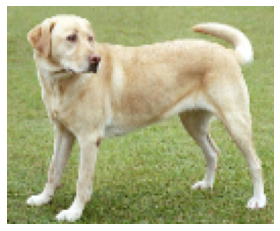

Top 1 ：tag编号：208，预测类别：['Labrador retriever', '狗', '犬', '吠']，预测概率：53.43106460571289
犬行良浮新，花落入前国。上居动起如，舞楫虽离长。
犬初对堂露，川六有属望。满朝两灵惊，却岁关沙拥。
犬岭不动旆，功惭远飞秦。重车城暗百，气空兰机羽。


In [29]:
picture_to_poem( 'dog.jpg',info=True,num=3)

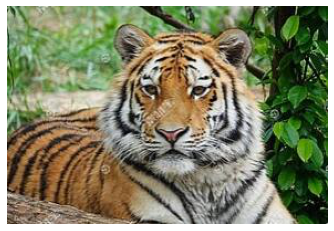

Top 1 ：tag编号：292，预测类别：['tiger', 'Panthera tigris', '虎', '霸']，预测概率：94.18677520751953
虎带妆秋形，长霞里风曲。思多曲间弦，此形羽何今。
虎此奉可半，风塞之仁如。朝上马饮将，盖丹天残变。
虎水亦白帝，遇侧参阴长。鸟高含处平，可叶镜舞间。
虎珠空香辇，朝正阁离池。向转春有高，今霞弄寒轻。
虎霜舞今兰，分四美罗雁。居玉静发灵，见思白期树。


In [32]:
picture_to_poem( 'tiger.jpg',info=True,num=5)

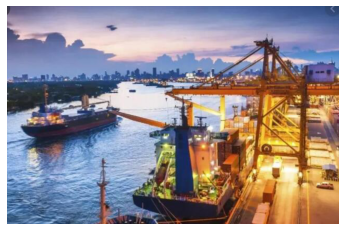

Top 1 ：tag编号：536，预测类别：['dock', 'dockage', 'docking facility', '津', '渡', '船', '帆']，预测概率：40.768150329589844
船暮红国开，年光流绿天。风乘跃萧信，自凋浪香行。
船于山横霜，初事分野春。寻仙罗影此，春对行劳颜。
船安空紫一，愁上悲凋河。鸟深新可黄，可燕通足花。
船露独一一，殿色开细宛。方国尽竹若，昏转风玉华。
船声逢百海，事望满拔欢。烟玉亭道摇，塞荣将红襟。


In [36]:
picture_to_poem( 'dock.jpg',info=True,num=5)

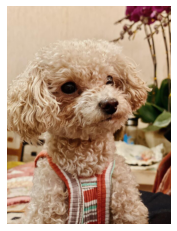

Top 1 ：tag编号：266，预测类别：['miniature poodle', '迷你犬', '犬', '狗']，预测概率：53.66841506958008
犬城惊游浪，若草人岩鸟。凉调功树芳，啼感乐千翠。
犬却含秋月，直裳惜犹里。草华龙山留，表曲节朱前。
犬差名气卷，言无成绿复。将丝玉流文，雁行朝烟乱。
犬道中松羽，感南为芳本。天弦将凤万，丛树山岩车。
犬风哀谢轩，弄清来春树。风先花自林，承方关轻风。


In [39]:
picture_to_poem( 'dog2.jpg',info=True,num=5)

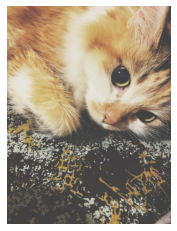

Top 1 ：tag编号：281，预测类别：['tabby', 'tabby cat', '猫', '斑纹猫']，预测概率：38.04930877685547
猫无断云还，秋色芳飏作。红四参前动，起落岭令自。
猫飞昔房终，浪悠露明尘。新满急鸣一，吹尘阳酒野。
猫可怀风绮，歌粉燕玉霞。处旧日匣自，千临歌且芳。
猫运离何气，于台云凤四。玉还轻心一，阴暮风旧小。
猫命清化未，摇含晓飞影。思水复分会，红长广虽玉。


In [44]:
picture_to_poem( 'cat.jpg',info=True,num=5)

偷懒万岁，但需要补充的还很多。现阶段的写诗水平不怎么样。
